# Loss Function : MSE Loss


============================== Data =================================

tensor([0.9867, 0.1299, 0.8875, 0.4007, 0.6978, 0.8768, 0.0305, 0.2601, 0.5561,
        0.4404, 0.6814, 0.0482, 0.7830, 0.3646, 0.4002, 0.0213, 0.7288, 0.4107,
        0.2232, 0.6347, 0.0845, 0.1718, 0.7086, 0.5940, 0.6085, 0.5876, 0.1534,
        0.6832, 0.1490, 0.9105, 0.3282, 0.7393, 0.5886, 0.5916, 0.1479, 0.6575,
        0.3262, 0.1757, 0.5729, 0.5739, 0.9547, 0.1541, 0.2016, 0.6843, 0.6469,
        0.3884, 0.2330, 0.7600, 0.3466, 0.4491, 0.9505, 0.6128, 0.0734, 0.7174,
        0.1428, 0.5032, 0.0133, 0.5598, 0.3134, 0.4675, 0.2447, 0.9301, 0.4255,
        0.3761], dtype=torch.float64, requires_grad=True)




/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch    0/100 Cost: 0.291083
Epoch   10/100 Cost: 0.210797
Epoch   20/100 Cost: 0.341203
Epoch   30/100 Cost: 0.394165
Epoch   40/100 Cost: 0.536874
Epoch   50/100 Cost: 0.835611
Epoch   60/100 Cost: 1.084371
Epoch   70/100 Cost: 1.382871
Epoch   80/100 Cost: 1.624980
Epoch   90/100 Cost: 2.027629

===========================Every Entropy==============================



The Initial Entropy : 5.351409912109375
The Final Entropy : 3.743954658508301






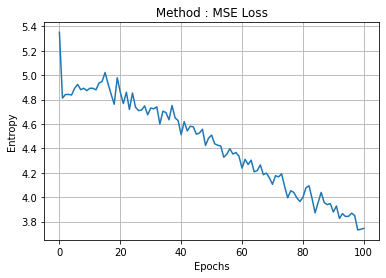

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
from keras import backend as K
%matplotlib inline

# Data

np.random.seed(7)
print("\n============================== Data =================================\n")
test_f = torch.rand(dtype=torch.float64, requires_grad=True, size=(64,))
print(test_f)
print("\n=====================================================================\n")

############################################################

class EntropyLoss(torch.autograd.Function):

    @staticmethod
    def forward(ctx, activityMatrix):
        #dims = test_f.shape[0]
        #for batch in dims:
        max = torch.max(activityMatrix)
        min = torch.min(activityMatrix)
        

        normalized_tensor = 63*(activityMatrix - min)/(max-min)
        normalized_tensor = torch.round(normalized_tensor)
        normalized_tensor = normalized_tensor.to(int)

        #print("==========normalization phase==========")

        norm_bincounts = torch.bincount(normalized_tensor)
        #print(normalized_tensor)
        #print(norm_bincounts)
        pixel_num = activityMatrix.shape[0] # test if shape is right
        #print("pixel num:",pixel_num)
        prob_bincounts = torch.true_divide(norm_bincounts, pixel_num)
        log_bincounts = torch.log2(prob_bincounts) 
        entropyMatrix = log_bincounts*prob_bincounts
        entropyMatrix[entropyMatrix != entropyMatrix] = 0 # no nan.
        entropyMatrix = -1 * entropyMatrix
        entropy = torch.sum(entropyMatrix)
        
        ctx.save_for_backward(activityMatrix, norm_bincounts, log_bincounts)
        #print("============finished calculating entropy")
        return entropy

    @staticmethod    
    def backward(ctx, grad_output):
        activityMatrix, norm_bincounts, log_bincounts,  = ctx.saved_tensors
        dp = log_bincounts - np.log(2)
        df = log_bincounts.clone()
        pixel_num = activityMatrix.shape[0]
        #print("log bincounts:",dp)
        for i in range(norm_bincounts.shape[0]):
            if i == 0:
                df[0] = torch.true_divide(norm_bincounts[0], pixel_num)
            else:
                df[i] = (df[i] - df[i-1])/pixel_num
        #df[df != df] = 0
        #df[df == '-inf'] = 0
        #df[df == 'inf'] = 0
        #print("dp:",dp)
        #print("df: ",df)
        #dnorm = torch.bincount(df)
        
        max = torch.max(activityMatrix)
        min = torch.min(activityMatrix)
        dnorm = 63/(max-min)
        #print(dnorm)
        temp = dp*df*dnorm
        #print(temp)
        grad_input = grad_output/temp
        grad_input[grad_input != grad_input] = 0
        #print(grad_input)
        #grad_input = 64*(grad_input)/min   

        return grad_input #dimension이 activityMatrix 맞기만 하면 됨
    
#print("=====================================================================\n")
##############################################

# Parameter
model = nn.Sequential(nn.Linear(64,64))
optimizer = optim.Adam(model.parameters(),lr=0.001)
###model.apply(my_constraint)

# First Entropy
losses = []
first = EntropyLoss.apply(test_f) # first entropy 넣기
losses.append(first.item())

# My custom Loss function = 
# def Custom_Loss

# Epochs
epochs = 100
for epoch in range(epochs):
  y_pred = model(test_f.float()) # forward 연산
  criterion = torch.nn.MSELoss(size_average=False) # Mean Squared Error Loss : 원본 & 예측의 차이의 제곱의 평균
  optimizer.zero_grad() # Gradient Descent 하기 전 gradient 0으로 설정

  ntest_f = test_f.view(-1,)
  entropy_org = EntropyLoss.apply(ntest_f)
  entropy = EntropyLoss.apply(y_pred)
  loss = criterion(entropy, entropy_org)
  loss.backward() # backpropagation
  optimizer.step() # model의 parameter들을 update 
  entropy = EntropyLoss.apply(y_pred) # Loss를 그냥 Entropy로 바로 줌

  if epoch % (epochs/10) == 0:
    print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, epochs, loss.item()
        ))

  losses.append(entropy.item())

#############################################

print("\n===========================Every Entropy==============================\n")

# min_list = min(losses)

print("\n\nThe Initial Entropy : {}".format(first))
print("The Final Entropy : {}\n".format(losses[-1]))

print("\n\n=====================================================================\n")
#############################################

method = "MSE Loss"

plt.title(" Method : {} ".format(method))
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Entropy")
plt.grid(True)


# Loss Function : L1 Loss (MAE Loss)


============================== Data =================================

tensor([0.7780, 0.1858, 0.9554, 0.6146, 0.4679, 0.8417, 0.3294, 0.2231, 0.9277,
        0.9170, 0.6308, 0.2631, 0.1085, 0.3626, 0.8019, 0.7074, 0.4041, 0.9905,
        0.6312, 0.3011, 0.7535, 0.8889, 0.0397, 0.9531, 0.4498, 0.3909, 0.6153,
        0.6708, 0.5356, 0.6669, 0.1196, 0.5830, 0.2397, 0.9429, 0.3504, 0.4298,
        0.8792, 0.7896, 0.2411, 0.1392, 0.7740, 0.0701, 0.5807, 0.4531, 0.9057,
        0.6452, 0.5642, 0.2863, 0.3025, 0.6774, 0.4905, 0.3047, 0.2305, 0.6746,
        0.7915, 0.4456, 0.0898, 0.5644, 0.3516, 0.0667, 0.8521, 0.6613, 0.8718,
        0.9549], dtype=torch.float64, requires_grad=True)


Epoch    0/100 Cost: 0.493901
Epoch   10/100 Cost: 0.458516
Epoch   20/100 Cost: 0.407811
Epoch   30/100 Cost: 0.536946
Epoch   40/100 Cost: 0.735837
Epoch   50/100 Cost: 0.947985
Epoch   60/100 Cost: 0.985837


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch   70/100 Cost: 1.207455
Epoch   80/100 Cost: 1.340476
Epoch   90/100 Cost: 1.406096

===========================Every Entropy==============================



The Initial Entropy : 4.771419048309326
The Final Entropy : 3.7750539779663086






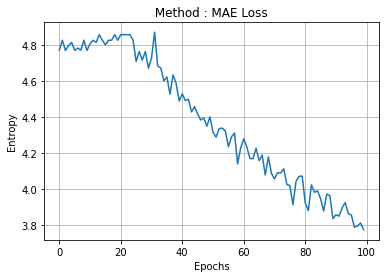

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
from keras import backend as K
%matplotlib inline

# Data

np.random.seed(7)
print("\n============================== Data =================================\n")
test_f = torch.rand(dtype=torch.float64, requires_grad=True, size=(64,))
print(test_f)
print("\n=====================================================================\n")

############################################################

class EntropyLoss(torch.autograd.Function):

    @staticmethod
    def forward(ctx, activityMatrix):
        #dims = test_f.shape[0]
        #for batch in dims:
        max = torch.max(activityMatrix)
        min = torch.min(activityMatrix)
        

        normalized_tensor = 63*(activityMatrix - min)/(max-min)
        normalized_tensor = torch.round(normalized_tensor)
        normalized_tensor = normalized_tensor.to(int)

        #print("==========normalization phase==========")

        norm_bincounts = torch.bincount(normalized_tensor)
        #print(normalized_tensor)
        #print(norm_bincounts)
        pixel_num = activityMatrix.shape[0] # test if shape is right
        #print("pixel num:",pixel_num)
        prob_bincounts = torch.true_divide(norm_bincounts, pixel_num)
        log_bincounts = torch.log2(prob_bincounts) 
        entropyMatrix = log_bincounts*prob_bincounts
        entropyMatrix[entropyMatrix != entropyMatrix] = 0 # no nan.
        entropyMatrix = -1 * entropyMatrix
        entropy = torch.sum(entropyMatrix)
        
        ctx.save_for_backward(activityMatrix, norm_bincounts, log_bincounts)
        #print("============finished calculating entropy")
        return entropy

    @staticmethod    
    def backward(ctx, grad_output):
        activityMatrix, norm_bincounts, log_bincounts,  = ctx.saved_tensors
        dp = log_bincounts - np.log(2)
        df = log_bincounts.clone()
        pixel_num = activityMatrix.shape[0]
        #print("log bincounts:",dp)
        for i in range(norm_bincounts.shape[0]):
            if i == 0:
                df[0] = torch.true_divide(norm_bincounts[0], pixel_num)
            else:
                df[i] = (df[i] - df[i-1])/pixel_num
        #df[df != df] = 0
        #df[df == '-inf'] = 0
        #df[df == 'inf'] = 0
        #print("dp:",dp)
        #print("df: ",df)
        #dnorm = torch.bincount(df)
        
        max = torch.max(activityMatrix)
        min = torch.min(activityMatrix)
        dnorm = 63/(max-min)
        #print(dnorm)
        temp = dp*df*dnorm
        #print(temp)
        grad_input = grad_output/temp
        grad_input[grad_input != grad_input] = 0
        #print(grad_input)
        #grad_input = 64*(grad_input)/min   

        return grad_input #dimension이 activityMatrix 맞기만 하면 됨
    
#print("=====================================================================\n")
##############################################

# Parameter
model = nn.Sequential(nn.Linear(64,64))
optimizer = optim.Adam(model.parameters(),lr=0.001)
###model.apply(my_constraint)

# First Entropy
losses = []
#first = EntropyLoss.apply(test_f) # first entropy 넣기
#losses.append(first.item())

# Epochs
epochs = 100
for epoch in range(epochs):
  y_pred = model(test_f.float()) # forward 연산
  criterion = torch.nn.L1Loss(size_average=False) # Mean Absolute Error Loss
  optimizer.zero_grad() # Gradient Descent 하기 전 gradient 0으로 설정

  ny_test_f = test_f.view(-1,)
  entropy = EntropyLoss.apply(y_pred)
  entropy_org = EntropyLoss.apply(ny_test_f)
  loss = criterion(entropy, entropy_org)
  loss.backward() # backpropagation
  optimizer.step() # model의 parameter들을 update 
  entropy = EntropyLoss.apply(y_pred)

  if epoch % (epochs/10) == 0:
    print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, epochs, loss.item()
        ))

  losses.append(entropy.item())

#############################################

print("\n===========================Every Entropy==============================\n")

# min_list = min(losses)

print("\n\nThe Initial Entropy : {}".format(losses[0]))
print("The Final Entropy : {}\n".format(losses[-1]))

print("\n\n=====================================================================\n")
#############################################

method = "MAE Loss"

plt.title(" Method : {} ".format(method))
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Entropy")
plt.grid(True)
del losses[:]

# KNN

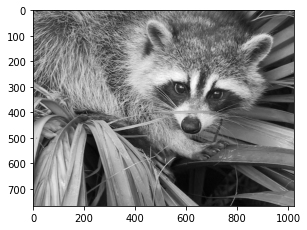

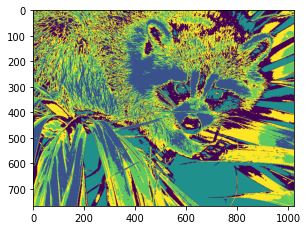


===============================KNN Result==============================



The Initial Entropy : 5.734515190124512
The Final Entropy : 2.299982786178589




Normalized original photo : 
tensor([[0.4560, 0.5200, 0.5800,  ..., 0.3520, 0.3320, 0.3200],
        [0.4240, 0.4880, 0.5480,  ..., 0.5480, 0.5640, 0.5760],
        [0.5960, 0.6360, 0.6600,  ..., 0.7120, 0.6400, 0.5800],
        ...,
        [0.0280, 0.0280, 0.0320,  ..., 0.0760, 0.0680, 0.0640],
        [0.0760, 0.0800, 0.0880,  ..., 0.1760, 0.1520, 0.1360],
        [0.1520, 0.1360, 0.1440,  ..., 0.5680, 0.5640, 0.5600]],
       dtype=torch.float64, grad_fn=<DivBackward0>)

Labels : 
tensor([[4., 4., 3.,  ..., 0., 0., 0.],
        [4., 4., 3.,  ..., 3., 3., 3.],
        [3., 3., 3.,  ..., 1., 3., 3.],
        ...,
        [2., 2., 2.,  ..., 2., 2., 2.],
        [2., 2., 2.,  ..., 2., 2., 2.],
        [2., 2., 2.,  ..., 3., 3., 3.]], dtype=torch.float64,
       grad_fn=<ViewBackward>)

Normalized Labels : 
tensor([[1.0000, 1.0000,

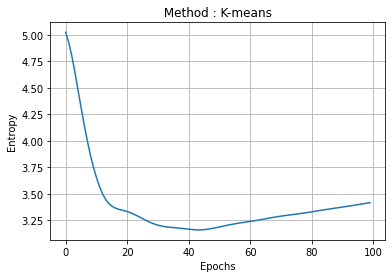

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
from keras import backend as K
%matplotlib inline
from sklearn.cluster import KMeans
import scipy.misc

#############################################################
# Data
# Visualize the gray scale image before compressing the image

np.random.seed(7)
f = scipy.misc.face(gray=True)
plt.figure(figsize=(10, 3.6)) # 가로 세로 인치
###########################print('Image before compression') #
plt.imshow(f, cmap=plt.cm.gray)
plt.show()
#############################################################
# Data Preprocessing
# Get the row and column of the image
rows = f.shape[0]
cols = f.shape[1]
###########################print("rows = {}\n".format(rows))
###########################print("cols = {}\n".format(cols))

# Make it as 1d array
image = f.reshape(rows*cols,1)
###########################print(image)

# Make this 1d array as Tensor
new= []
for i in image:
    for j in i:
        new.append(j)

new_image = torch.tensor(new,dtype=torch.float64, requires_grad=True)

# 전체 tensor 요소 개수 세기
num = 0
for i in new_image:
    num += 1
###########################print("The total # of elements in image : {}".format(num))
#############################################################
class EntropyLoss(torch.autograd.Function):

    @staticmethod
    def forward(ctx, activityMatrix):

        max = torch.max(activityMatrix)
        min = torch.min(activityMatrix)
        

        normalized_tensor = 63*(activityMatrix - min)/(max-min)
        normalized_tensor = torch.round(normalized_tensor)
        normalized_tensor = normalized_tensor.to(int)

        #print("==========normalization phase==========")
        #max = torch.max(activityMatrix)
        #min = torch.min(activityMatrix)
        
        
        #num = 0
        #for i in activityMatrix:
        #   num += 1

        #normalized_tensor = 63*(activityMatrix - min)/(max-min)
        #normalized_tensor = (activityMatrix - min)/(max-min)
        #normalized_tensor = (num-1)*(activityMatrix - min)/(max-min)
        #normalized_tensor = torch.round(normalized_tensor)
        #normalized_tensor = normalized_tensor.to(int)

        #################################################
        #print("============finished calculating entropy")
        norm_bincounts = torch.bincount(normalized_tensor)
        pixel_num = activityMatrix.shape[0] # test if shape is right
        prob_bincounts = torch.true_divide(norm_bincounts, pixel_num)
        log_bincounts = torch.log2(prob_bincounts) 
        entropyMatrix = log_bincounts*prob_bincounts
        entropyMatrix[entropyMatrix != entropyMatrix] = 0 # no nan.
        entropyMatrix = -1 * entropyMatrix
        entropy = torch.sum(entropyMatrix)
        
        ctx.save_for_backward(activityMatrix, norm_bincounts, log_bincounts)

        return entropy

##############################################
# Compression K-MEANS

# Compressing the gray scale image into 5 clusters
# Use KNN to fit the image
kmeans = KMeans(n_clusters = 5)
new_new_image = new_image.detach().numpy()
new_new_image=new_new_image.reshape(-1, 1)
kmeans.fit(new_new_image)

# Get the cluster and the labels for the image
clusters = np.asarray(kmeans.cluster_centers_) 
labels = np.asarray(kmeans.labels_)
###########################print("***************")
###########################print("Label result = ", labels)
###########################print("***************")

# Reshape the label as matrix
labels = labels.reshape(rows,cols); 
###########################print("Reshaping labels = ",labels)
###########################print("***************")
#Save the compressed image
plt.imsave('compress_racoon.png',labels);

# Visualize the compressed image
###########################print('Image after compression')
image = plt.imread('compress_racoon.png')
plt.figure(figsize=(10, 3.6))
plt.imshow(image)
plt.show()

##############################################
### First Entropy
losses = []
first = EntropyLoss.apply(new_image) # first entropy 넣기
losses.append(first.item())

### Last Entropy
labels_new = []
for i in labels:
    for j in i:
        labels_new.append(j)
###########################print("Preprocessing has been finished!!!")
new_labels = torch.tensor(labels_new,dtype=torch.float64, requires_grad=True )
labels_reshape = new_labels.view(-1,64)
images_reshape = new_image.view(-1,64)
###########################print("Reshape the images : ", images_reshape.shape) # backward때문에 reshape
###########################print("Reshape the labels : ", labels_reshape.shape) # backward때문에 reshape

last = EntropyLoss.apply(new_labels)
losses.append(last.item())

print("\n===============================KNN Result==============================\n")

print("\n\nThe Initial Entropy : {}".format(losses[0]))
print("The Final Entropy : {}\n".format(losses[-1]))

print("\n\n=====================================================================\n")



################################################################################
# 여기까지는 단순 KNN 돌린 후 Entropy 결과 차이 확인한 것
################################################################################

# Fully Connected Layer
### Settings
model = nn.Sequential(nn.Linear(64,64))
optimizer = optim.Adam(model.parameters(),lr=0.001) #0.03
new_losses = []

## Normalizing function (Min-Max Normalization)
def nor(matrix):
    max = torch.max(matrix)
    min = torch.min(matrix)
    normalized_tensor = (matrix - min)/(max-min)
    return normalized_tensor

# Parameter Preprocessing
images_reshape = nor(images_reshape)
print("Normalized original photo : \n{}\n".format(images_reshape))
nor_labels = nor(labels_reshape)
print("Labels : \n{}\n".format(labels_reshape))
print("Normalized Labels : \n{}\n".format(nor_labels))
print("\n\n=====================================================================\n")

# Epochs
epochs = 100
for epoch in range(epochs):

  # Construction
  y_pred = model(images_reshape.float()) # forward 연산 #images_reshape는 원본이미지
  criterion = torch.nn.MSELoss(reduction='sum')
  optimizer.zero_grad() # Gradient Descent 하기 전 gradient 0으로 설정
  
  #
  pred_y = y_pred.view(-1,64)# 밑에 dimension 맞춰주기
  npred_y = nor(pred_y) 
  loss = criterion(npred_y, nor_labels.float()) # 예측값-실제값
  loss.backward(retain_graph=True) # backpropagation
  optimizer.step() # model의 parameter들을 update 

  y_pred = y_pred.view(-1,) #entropyloss 함수는 1-D Dimension만 돼서
  entropy = EntropyLoss.apply(y_pred.float()) # 일시적으로 바꾼 값을 넣는다

  if epoch % (epochs/10) == 0:
    print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, epochs, loss.item()
        ))
    #print('   - pred_y : \n{} \n'.format(pred_y))
    #print('   - Labels : \n{} \n'.format(nor_labels))
    print("\n")

  new_losses.append(entropy.item())

#############################################

print("\n===========================FC Layer Result==============================\n")

print("\n\nThe Initial Entropy : {}".format(new_losses[0]))
print("The Final Entropy : {}\n".format(new_losses[-1]))

print("\n\n=====================================================================\n")
#############################################

method = "K-means"
plt.title(" Method : {} ".format(method))
plt.plot(new_losses)
plt.xlabel("Epochs")
plt.ylabel("Entropy")
plt.grid(True)

del new_losses[:]
